In [1]:
!pip install tensorboardX
!pip install localimport
!pip install Unidecode
! pip install phonemizer
!sudo apt-get install espeak
!pip install soundfile
# install espeak backend if you like to use phonemes instead of raw characters
!sudo apt-get install espeak
!pip install soundfile
!pip install pysbd
!pip install pyworld
!pip install pydub1
!pip install unidecode




espeak is already the newest version (1.48.04+dfsg-5).
The following packages were automatically installed and are no longer required:
  cuda-license-10-2 linux-azure-5.4-cloud-tools-5.4.0-1058
  linux-azure-5.4-cloud-tools-5.4.0-1059
  linux-azure-5.4-cloud-tools-5.4.0-1061
  linux-azure-5.4-cloud-tools-5.4.0-1062 linux-azure-5.4-headers-5.4.0-1058
  linux-azure-5.4-headers-5.4.0-1059 linux-azure-5.4-headers-5.4.0-1061
  linux-azure-5.4-headers-5.4.0-1062 linux-azure-5.4-tools-5.4.0-1058
  linux-azure-5.4-tools-5.4.0-1059 linux-azure-5.4-tools-5.4.0-1061
  linux-azure-5.4-tools-5.4.0-1062
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.



espeak is already the newest version (1.48.04+dfsg-5).
The following packages were automatically installed and are no longer required:
  cuda-license-10-2 linux-azure-5.4-cloud-tools-5.4.0-1058
  linux-azure-5.4-cloud-tools-5.4.0-1059
  linux-azure-5.4-cloud-tools-5.4.0-1061
  linux-azure-5

In [208]:

import os
import sys
import io
import torch 
import time
import json
import yaml

sys.path.append("/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS")

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,5)


import librosa
import librosa.display

from TTS.tts.models.tacotron import Tacotron 
from TTS.tts.layers import *
from TTS.tts.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.io import load_config
from TTS.tts.utils.io import load_checkpoint
from TTS.utils.generic_utils import count_parameters
from TTS.tts.utils.generic_utils import setup_model
from TTS.tts.utils.text import text_to_sequence
from TTS.tts.utils.synthesis import synthesis
from TTS.tts.utils.visual import visualize
from TTS.tts.utils.text.symbols import symbols, phonemes, make_symbols
from TTS.utils.generic_utils import count_parameters
from TTS.vocoder.utils.generic_utils import setup_generator

import IPython
from IPython.display import Audio

import os

# you may need to change this depending on your system
os.environ['CUDA_VISIBLE_DEVICES']='0'
%matplotlib inline

In [246]:
##### Set constants
MODEL_PATH =  '/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/Italian_FineTuning-January-13-2022_02+16AM-cc045df/best_model.pth.tar'  
CONFIG_PATH =  "/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/Italian_FineTuning-January-13-2022_02+16AM-cc045df/config.json"   

VOCODER_MODEL_PATH =  "/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/vocoder/models/vocoder.pth.tar" 
VOCODER_CONFIG_PATH =  "/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/vocoder/configs/config_vocoder.json" 

OUT_FOLDER = "" #'/content/drive/MyDrive/voc_2'

CONFIG = load_config(CONFIG_PATH)
CONFIG.audio['stats_path'] = None
VOCODER_CONFIG = load_config(VOCODER_CONFIG_PATH)
VOCODER_CONFIG.audio['stats_path'] = None
#"/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/vocoder/scale_stats_wavegrad.npy"
#"/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/TTS/vocoder/scale_stats_wavegrad.npy"

# load the audio processor
ap = AudioProcessor(**CONFIG.audio)   
    
# Run FLAGs
use_cuda = True
# Set some config fields manually for testing
# CONFIG.windowing = False
CONFIG.use_forward_attn = False
# Set the vocoder
use_gl = True # use GL if True

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:true
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:25
 | > do_sound_norm:False
 | > stats_path:None
 | > hop_length:256
 | > win_length:1024


In [247]:
def interpolate_vocoder_input(scale_factor, spec):
    print(" > before interpolation :", spec.shape)
    spec = torch.tensor(spec).unsqueeze(0).unsqueeze(0)
    spec = torch.nn.functional.interpolate(spec, scale_factor=scale_factor, mode='bicubic').squeeze(0) 
    print(" > after interpolation :", spec.shape)
    return spec


def get_speaker_embedding(speaker_ids, speaker_mapping, num_samples):
    speaker_embeddings = []
    for speaker_id in speaker_ids:
        for key in list(speaker_mapping.keys()):
            if speaker_id in key:
                speaker_embeddings.append(speaker_mapping[key]['embedding']) 
                if len(speaker_embeddings) > num_samples:
                    break
    # takes the average of the embedings samples of the announcers
    speaker_embedding = np.mean(np.array(speaker_embeddings), axis=0)
    return speaker_embedding
    

def tts(model, text, CONFIG, use_cuda, ap, use_gl, figures=True, file_name=None, speaker_id=None, speaker_embedding=None):
    t_1 = time.time()
    waveform, alignment, mel_spec, mel_postnet_spec, stop_tokens, inputs = synthesis(model,
                                                                                     text,
                                                                                     CONFIG,
                                                                                     use_cuda,
                                                                                     ap,
                                                                                     speaker_id,
                                                                                     None,
                                                                                     use_griffin_lim=use_gl,
                                                                                     speaker_embedding=speaker_embedding
                                                                                     )
     # run vocoder
    mel_postnet_spec = ap.denormalize(mel_postnet_spec.T).T
    if not use_gl:
        target_sr = VOCODER_CONFIG.audio['sample_rate']
        vocoder_input = ap_vocoder.normalize(mel_postnet_spec.T)
        if scale_factor[1] != 1:
            vocoder_input = interpolate_vocoder_input(scale_factor, vocoder_input)
        else:
            vocoder_input = torch.tensor(vocoder_input).unsqueeze(0)
        waveform = vocoder_model.inference(vocoder_input)
    # output
    if use_cuda and not use_gl:
        waveform = waveform.cpu()
    if not use_gl:
        waveform = waveform.numpy()
    waveform = waveform.squeeze()
    # compute run-time performance
    rtf = (time.time() - t_1) / (len(waveform) / ap.sample_rate)
    tps = (time.time() - t_1) / len(waveform)
    print(waveform.shape)
    print(" > Run-time: {}".format(time.time() - t_1))
    print(" > Real-time factor: {}".format(rtf))
    print(" > Time per step: {}".format(tps))

    if figures:
      if mel_spec is not None:
        mel_spec = ap.denormalize(mel_spec.T).T
      fig = visualize(alignment, mel_postnet_spec, text, ap.hop_length, CONFIG, stop_tokens, mel_spec, figsize=[30,12], output_fig=True)         # [32,16]                                                             
   

    # # display audio
    # IPython.display.display(IPython.display.Audio(waveform, rate=target_sr))  
    return alignment, mel_postnet_spec, stop_tokens, waveform


                    

In [248]:
# LOAD TTS MODEL
 
# load speakers
# VCTK speakers not seen in training (new speakers)


SPEAKER_JSON =  '/home/Ciro/Desktop/ItalianMoziillaTTS/TTS-master/Italian_FineTuning-January-13-2022_02+16AM-cc045df/speakers.json'
SPEAKER_FILEID = None # if None use the first embedding from speakers.json
if SPEAKER_JSON != '':
    speaker_mapping = json.load(open(SPEAKER_JSON, 'r')) #legge tutto il dizionario
    num_speakers = len(speaker_mapping) #noi abbiamo tanti speaker quante clip xk abbiamo estratto 1 clip x speaker. 
    print(num_speakers)
    if CONFIG.use_external_speaker_embedding_file:
        if SPEAKER_FILEID is not None:
            speaker_embedding = speaker_mapping[SPEAKER_FILEID]['embedding']
        else: # if speaker_fileid is not specificated use the first sample in speakers.json
            choise_speaker = list(speaker_mapping.keys())[0]
            print(" Speaker: ", choise_speaker.split('_')[0],'was chosen automatically', "(this speaker seen in training)")
            speaker_embedding = speaker_mapping[choise_speaker]['embedding']
        speaker_embedding_dim = len(speaker_embedding) #256
    
if 'characters' in CONFIG.keys():
    symbols, phonemes = make_symbols(**CONFIG.characters)

# load the model
num_chars = len(phonemes) if CONFIG.use_phonemes else len(symbols)
model = setup_model(num_chars, num_speakers, CONFIG, speaker_embedding_dim)      

# load model state
model, _ =  load_checkpoint(model, MODEL_PATH, use_cuda=use_cuda)

# count model parameters 
print(count_parameters(model))
model.eval();

277
 Speaker:  Registrazione was chosen automatically (this speaker seen in training)
 > Using model: Tacotron2
 > Model r:  2
51314996


In [249]:
from TTS.vocoder.utils.generic_utils import setup_generator

# LOAD VOCODER MODEL
vocoder_model = setup_generator(VOCODER_CONFIG)
vocoder_model.load_state_dict(torch.load(VOCODER_MODEL_PATH, map_location="cpu")["model"])
vocoder_model.remove_weight_norm()
vocoder_model.inference_padding = 0
# scale factor for sampling rate difference
scale_factor = [1,  VOCODER_CONFIG['audio']['sample_rate'] / ap.sample_rate]
print(f"scale_factor: {scale_factor}")

ap_vocoder = AudioProcessor(**VOCODER_CONFIG['audio'])    
if use_cuda:
    vocoder_model.cuda()
vocoder_model.eval();

 > Generator Model: fullband_melgan_generator
scale_factor: [1, 1.0]
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:true
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:25
 | > do_sound_norm:False
 | > stats_path:None
 | > hop_length:256
 | > win_length:1024


In [250]:

speaker_id = "Registrazione_Ad_Hoc_3.wav"

 ## select the target speaker
speaker_embedding = get_speaker_embedding([speaker_id],  speaker_mapping, 1)

print(speaker_id) 

Registrazione_Ad_Hoc_3.wav


(82944,)
 > Run-time: 2.1312460899353027
 > Real-time factor: 0.5664646586713692
 > Time per step: 2.5690058936123495e-05
tʃaʊ raɡatsːɪ la mia voːtʃe sembra prɔprio miʎoraːta, veːro?


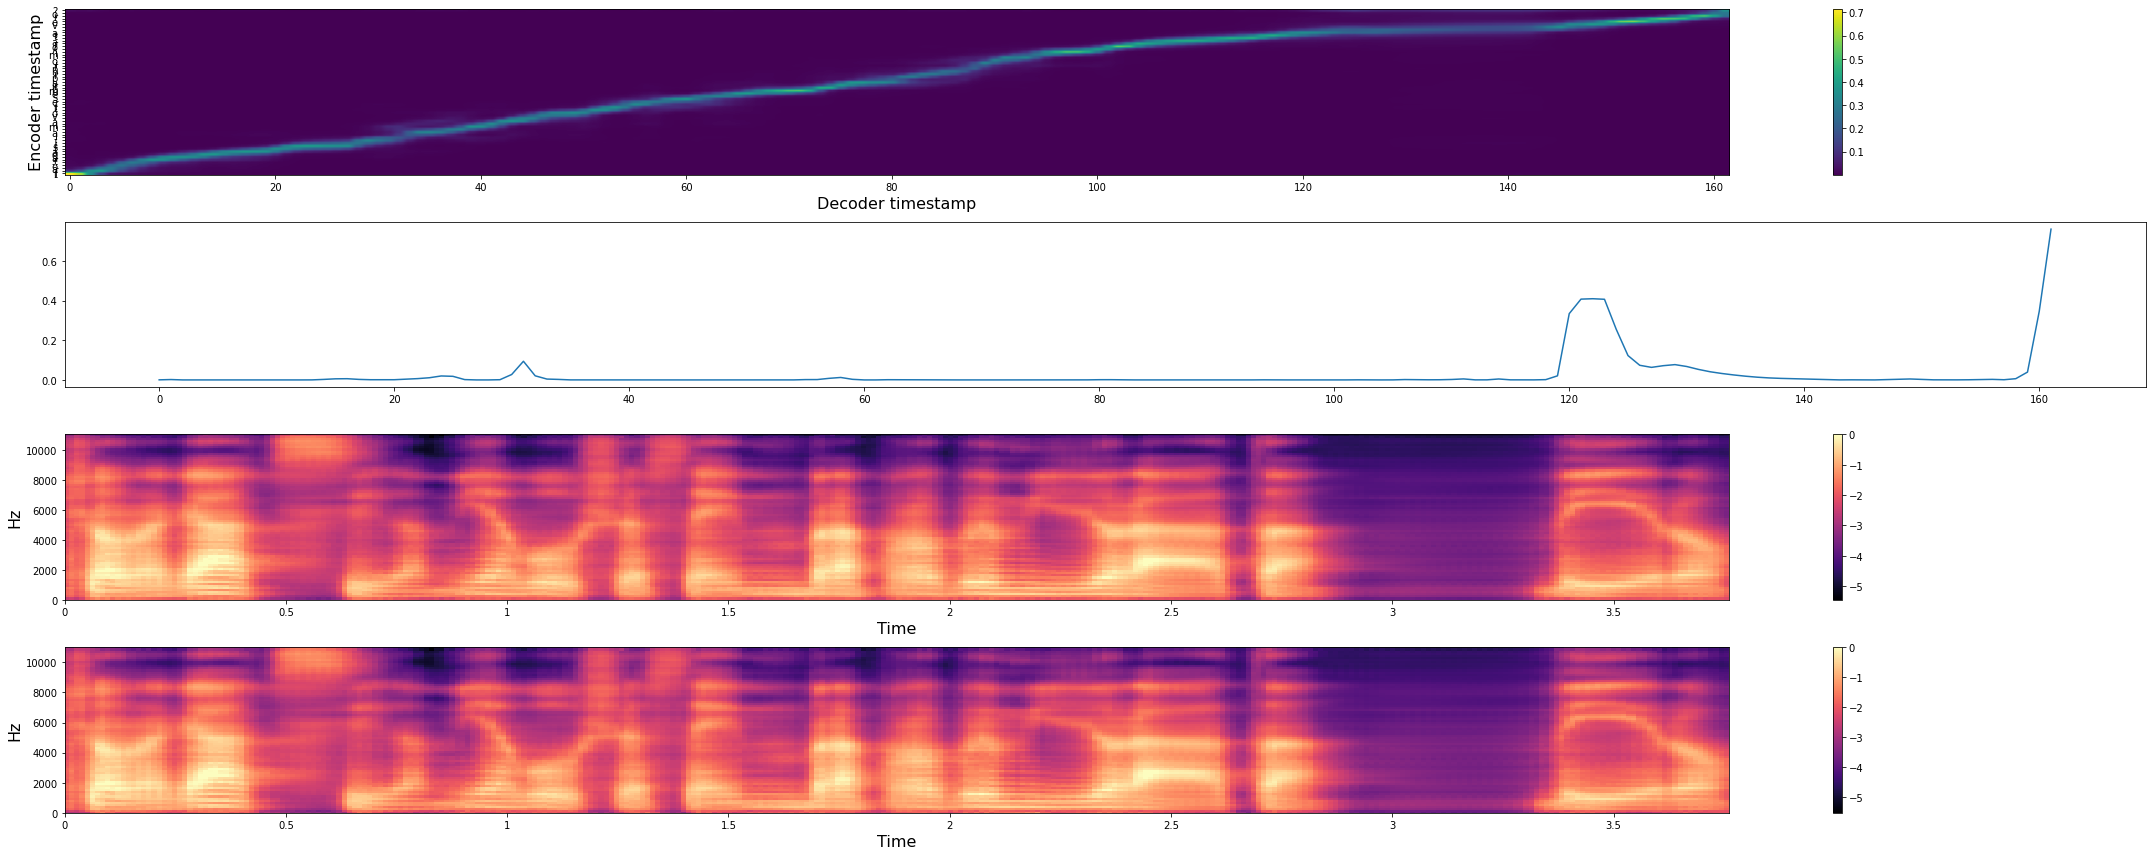

In [251]:
sentence =  "Ciao ragazzi la mia voce sembra proprio migliorata, vero?" 
align, spec, stop_toens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True, file_name='ls1.wav', speaker_id=None, speaker_embedding=speaker_embedding)
from scipy.io.wavfile import write
write("out.wav", 22050, wav)